# ProteinGAN: Generative Adversarial Network for Functional Protein Generation
*Please note that this is an optional notebook that is meant to introduce more advanced concepts, if you're up for a challenge. So, don't worry if you don't completely follow every step! We provide external resources for extra base knowledge required to grasp some components of the advanced material.*

[ProteinGAN](https://www.biorxiv.org/content/10.1101/789719v2) was developed by [Biomatters Designs](https://www.biomatterdesigns.com/) and [Zelezniak lab at Chalmers University of Technology](https://twitter.com/AZelezniak).

## Goal
The goal of this notebook is to demonstrate that core GAN ideas can be applied outside of the image domain. In this notebook, you will be able to play around with a pre-trained ProteinGAN model to see how it can be used in bioinformatics to generate functional molecules.


## Background


### Proteins

Proteins are large, complex molecules that play many critical roles in living organisms, including humans. You can think of them as very tiny, programmable robots used by nature to perform various functions, e.g. building, modifying or breaking down other molecules, aiding in cell replication and division, and transporting other proteins inside of cells. Apart from the crucial cellular functions, proteins are used virtually everywhere in our daily life, starting from animal nutrition and washing powders down to costly drugs and therapeutic antibodies. Using synthetic biology, protein engineering, adaptive evolutions experimental techniques, researchers enhance proteins' properties, making them more active or "sticky" towards a particular drug target or resistant to harsh environemental conditions. However, it is challenging to randomly modify proteins in a "biochemically meaningful" way such that protein would remain functional leading in a very costly time-consuming experiments. Thus generating natural-like diverse proteins that remain functional is of outstanding importance for biotechnology and biomedical applications.


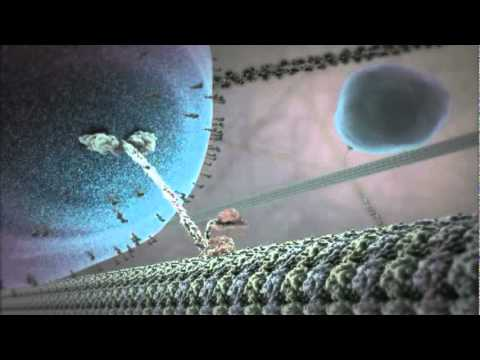

In [2]:
from IPython.display import YouTubeVideo
YouTubeVideo('wJyUtbn0O5Y', start=75, end=80, autoplay=1, controls=0, loop=1, width=800, height=600)

*Above, animation of motor protein responsible for transporting objects in cells*

Source: https://www.youtube.com/watch?v=wJyUtbn0O5Y


Proteins, like images, can be represented in various ways on the computer. Images are represented as integers from 0 to 256 that indicate the intensity of red, green, or blue (RGB) color. Proteins, similarly, use letters to represent 20 unique amino acids, like the one below:

> MKYATLLEYAFQALKNSYAPYSRFRVGAALLSDDGEVVTGCNVENASYGLSMCAERTAVFRAVAQGVKKFDAIAVVSGKVNPVYPCGACRQVLREFNPRLTVVVAGPGKKPLTTSLDKLLPKSFGKESLRRR

Raw pixel RGB values are easy for computers to work with, though they are not very meaningful to the human eye, which is why they are displayed as images on the screen. Similarly, the sequence of amino acids is a compact, convenient representation of the actual molecule, while the more meaningful view of the protein molecule is its 3D structure. For an example, see [Cytidine deaminase](https://colab.research.google.com/drive/1O0_wyl3i-9F-5mDTlShaMfR2uOWHKwwE#scrollTo=Q277ab8R9WEU).

For you to appreciate and reason about the outputs, you want your models (GANs) to ultimately produce meaningful structures. There are two important common features that make images and proteins both suitable candidates for GANs:

* A random combination of building blocks, whether amino acids or pixels, will not produce a realistic outcomes. This means the GAN cannot simply guess! There are meaningful, realistic patterns of pixels and amino acids that it must model and generate.
* The mathematical formula for how to evaluate the correctness of the generated item is unknown. For images, correctness is  "realism" -- how realistic does a generated image of a dog look? There's no math formula for that, so instead you have another model (the discriminator!) learn to assess that. The same goes for proteins.


|         | Image      | Protein  |
| ------- |:----------:| --------:|
| Data type | integers from 0 to 256 | vocab of 20 amino acids |
| Dimension| 2D | 1D|
| Number of possible variants | $3*256^{size}$ |  $20^{length}$  |




### ProteinGAN

ProteinGAN is a generative adversarial network adapted to generate functional protein sequences. At its core, it consists of common building blocks: a discriminator and generator, spectral normalization (as in the [SN-GAN optional notebook](https://www.coursera.org/learn/build-basic-generative-adversarial-networks-gans/ungradedLab/c2FPs/optional-sn-gan)), and a loss function based on earth mover's distance (as in the [WGAN-GP assignment](https://www.coursera.org/learn/build-basic-generative-adversarial-networks-gans/programming/mTm3U/wgan)), etc.

To make the GAN concept work in the field of synthetic biology, the generator and discriminator architectures have been modified to handle sequences of categorical values, capture long-distance relationships, as well as discriminate between various areas in the sequences. This is a major difference from pixel values in images and helps specifically with this type of long, categorical, and sequential data. One question to mull over: could this data processing and understanding help with generating text?


**Data pre-processing.** The explored protein space is very unevenly distributed. Some proteins and their close variants are widely studied while others are just recorded in public databases. Without the balancing, the neural network mainly focuses on big clusters of similar well-studied sequences while treating unrepresented cluster members as anomalies. ProteinGAN has in-built upsampling capability to balance the dataset based on the size of the cluster in order to preserve the diversity of sequences.

**Discrete values.** One of the biggest differences between images and proteins is the data type: while images consist of continuous values, proteins are built from discrete building blocks. To address this challenge for backpropagation, ProteinGAN employs the [Gumbel-Softmax trick with temperature](https://arxiv.org/abs/1611.01144), which serves as a differentiable approximation to sampling discrete data. This allows to end-to-end training of the discriminator and generator while operating in discrete input space.

**Convergence.** GANs are known to be difficult to train due to stability issues. The discrete nature of the input further aggravates this problem. Despite the implementation of spectral normalization and WGAN loss, the optimization of ProteinGAN did not lead to convergence. However, as demonstrated in [this paper](https://arxiv.org/abs/1801.04406), training with zero-centered gradient penalties leads to improved training and guarantees local convergence even if data and generator distributions are not continuous. Adapting the implementation of [non-saturating loss with R1 regularization](https://arxiv.org/abs/1801.04406) greatly improves the performance of the GAN as demonstrated in the figure below.


![Loss performance](https://drive.google.com/uc?export=view&id=1GBwiEm328DeLV29F7gUzUHP-o1uIYqSK)

> *GAN performance in the first 35k steps using different losses. Model performances were measured using [BLOSUM45 scores](https://en.wikipedia.org/wiki/BLOSUM) (in the nutshell, similarity score which takes into account substitution probabilities of amino acids in known seuqences) against training sequences for the first 35,000 steps (average of 3 runs with different random seeds).*


For more information please refer [ProteinGAN paper](https://www.biorxiv.org/content/10.1101/789719v2)

## Setup

In [ ]:
# Installing dependencies
#! pip install biopython
#! pip install py3Dmol
#! apt-get install -y clustalo

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [4]:
# Downloading pre-trained ProteinGAN model
!gdown https://drive.google.com/uc?id=1vuxHqsRHc-K-gqXK7AJqaC54f7PtKmOX
!unzip pre_trained_protein_gan.zip

Downloading...
From (original): https://drive.google.com/uc?id=1vuxHqsRHc-K-gqXK7AJqaC54f7PtKmOX
From (redirected): https://drive.google.com/uc?id=1vuxHqsRHc-K-gqXK7AJqaC54f7PtKmOX&confirm=t&uuid=c3a426a4-af80-4013-a5ab-b312153e608a
To: /usr/src/JupyterNotebooks/Coursera/GAN/pre_trained_protein_gan.zip
100%|████████████████████████████████████████| 466M/466M [07:36<00:00, 1.02MB/s]
Archive:  pre_trained_protein_gan.zip
   creating: pre_trained_protein_gan/
  inflating: pre_trained_protein_gan/saved_model.pb  
  inflating: pre_trained_protein_gan/train_rep.fasta  
   creating: pre_trained_protein_gan/variables/
  inflating: pre_trained_protein_gan/variables/variables.data-00000-of-00001  
  inflating: pre_trained_protein_gan/variables/variables.index  


In [5]:
# Helper methods
import shutil

from Bio.Blast import NCBIWWW
from Bio.Blast import NCBIXML

import numpy as np
import pandas as pd

import py3Dmol

# A mapping between amino acids ids and their corresponding letters
ID_TO_AMINO_ACID = {0: '0', 1: 'A', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'K', 10: 'L', 11: 'M', 12: 'N', 13: 'P', 14: 'Q', 15: 'R', 16: 'S', 17: 'T', 18: 'V', 19: 'W', 20: 'Y'}

def to_seqs(model_output):
  """Takes ProteinGAN output and returns list of generated protein sequences"""
  human_readable_seqs = []
  seqs = model_output["prediction"]
  for i in range(len(seqs)):
    human_readable_seq ="".join([ID_TO_AMINO_ACID[a] for a in seqs[i].numpy()])
    human_readable_seq = human_readable_seq.replace("0", "")
    human_readable_seqs.append(human_readable_seq)
  return human_readable_seqs

def get_blast_results(seq):
  """Takes a protein sequence, calls BLAST server and returns parsed results"""
  print("Calling BLAST server. This might take a while")
  r = NCBIWWW.qblast("blastp", "nr", seq, hitlist_size = 5, expect=0.5,
                     word_size=6, matrix_name="BLOSUM62")
  blast_record = NCBIXML.read(r)

  to_df = []

  for a in blast_record.alignments:
    to_df.append({"name": a.hit_def,"identity": a.hsps[0].identities,
                  "subject": a.hsps[0].sbjct})

  return pd.DataFrame(to_df)

def append_to_fasta(path, seqs, prefix):
  """Appends new sequences to existing file in FASTA format."""
  fasta = ""
  for i, seq in enumerate(seqs):
    fasta += f">{prefix}_{i}\n{seq}\n"
  print(fasta, file=open(path, 'a'))

def interpolate(starting, ending, steps):
  """
  Interpolates between starting and end points. Steps parameter determines
  how many interpolated points will be returned.
  """
  points = [starting]
  step = (ending-starting)/steps
  for i in range(steps):
    starting = starting + step
    points.append(starting)
  return np.asanyarray(points)

## Cytidine deaminase
This demonstration will use a relatively small protein called *cytidine deaminase* for simplicity. Its function in organisms is essential to DNA and RNA degradation. **Our aim is to be able to create variants of this protein that exhibit different properties.**

Below is an example of cytidine deaminase 3D structure.


In [6]:
view = py3Dmol.view(query='pdb:1UX1')
view.setStyle({'cartoon':{'color':'spectrum'}})
print("Cytidine deaminase")
view

Cytidine deaminase


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## Random amino acid sequence

Let's consider a very naive approach first: choosing amino acids at random. As mentioned before, only a very tiny portion of amino acids can make up a protein with a desired function. So... what are the odds?

There are around 17k annotated sequences that are categorized as cytidine deaminase: [see here](https://www.uniprot.org/uniprot/?query=ec%3A3.5.4.5+taxonomy%3A%22Bacteria+%5B2%5D%22+length%3A%5B64+TO+256%5D&sort=score)

The protein length varies depending on the organism, but let's say you want to generate 131 length cytidine deaminase. So there are:  $20^{131}$ possible combinations (just for comparison: there are ~ $10^{80}$ atoms in the observable universe!)

It's safe to say that random sequences are unlikely to work. Even brute forcing all combinations is not an option. Nevertheless, let's try to generate a sequence to see what happens. :)


In [7]:
np.random.seed(42)
random_seq = "".join(np.random.choice(list(ID_TO_AMINO_ACID.values())[1:], 131))
random_seq

'HYRMIHWMMEIDCNGCANNTLSRRWNYDFWHKHVEQVKCYRHNIRDQTEVIECGLEVNCLEQSRIQISPVRPKRPAHKANIMWTIDDAFLHKHKINCASFDNIDADFRQDAFQHKRRLPWHTYEFHPRMEP'

Here, you see a 131 letter long amino acid sequence. It is hard to tell anything about this sequence only by looking. So instead, you can use a bioinformatics tool called Blast [(Basic Local Alignment Search Tool)](https://blast.ncbi.nlm.nih.gov/Blast.cgi) that searches a large database of known proteins to find the most similar matches. In most cases, a random sequence should not return any high-similarity results.

If you do get anything returned, it should have a small _identity value_, which is the percentage of the sequence that matches. When the identity value is small, this means that only a small fragment of the sequence could be identified as a part of some random protein.

In [8]:
get_blast_results(random_seq)

Calling BLAST server. This might take a while


""


## ProteinGAN sequences

What if, instead, you train a GAN to generate desirable (realistic, reasonable, non-random) protein sequences?


In [9]:
import tensorflow as tf
tf.random.set_seed(42)
from absl import logging
logging.set_verbosity("ERROR")
tf.get_logger().setLevel("ERROR")

# Loading pre-trained model.
model = tf.saved_model.load("pre_trained_protein_gan/").signatures["serving_default"]

2025-10-23 18:10:57.198851: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-23 18:10:57.480396: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-23 18:10:58.697044: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
I0000 00:00:1761214259.921807 1323935 gpu_device.cc:2020] Created device /job:lo

In [ ]:
# Choosing random points from latent space.
noise = tf.random.truncated_normal([64, 128], stddev=0.5, dtype=tf.float32)

# Feeding noise to generator to get an output.
model_output = model(noise)

# Model returns indices of amino acids. Here we convert them to actual letters.
seqs = to_seqs(model_output)
seqs[0]

Again, not much can be said about the sequence just by looking at it (unless you're a protein savant). Time to run BLAST again!

In [ ]:
get_blast_results(seqs[0])

Nice! This time, you got some matches that are either cytidine deaminase or other types of deaminase with a high indentity. This is a good indication that the GAN works well in generating realistic protein sequences.

## Latent space

As you already know, GANs learn to map points in the latent space to generated items. You can explore this latent space and perform a meaningful modifications to a generated item by moving in different directions. On generated faces, that might be changing hair color or adding sunglasses. Here, it's also to change something semantically meaningful, but for protein sequences.

To start off, you can play with the diversity of generated sequences by changing how widely you sample the latent space. This can be achieved by modifying the standard deviation of the distribution. Let's try 0.1 and 1.0 to start!

In [ ]:
# Generating sequences from points which are close to each other
model_output = model(tf.random.truncated_normal([64, 128], stddev=0.1, dtype=tf.float32))
small_var_seqs = to_seqs(model_output)

# Generating sequences more distrbuted points
model_output = model(tf.random.truncated_normal([64, 128], stddev=1.0, dtype=tf.float32))
large_var_seqs = to_seqs(model_output)

In [ ]:
# Creating fasta files which will be used for clustalo to calculate distances
#pre_trained_protein_gan/train_rep.fasta - contains some representative sequences of training dataset
shutil.copy("pre_trained_protein_gan/train_rep.fasta","sequences.fasta")
#Appending generated sequences to training sequences
append_to_fasta("sequences.fasta", small_var_seqs, "small_var")
append_to_fasta("sequences.fasta", large_var_seqs, "large_var")

[Clustalo](http://www.clustal.org/omega/) is a bioinformatics tool for biological sequence alignment and comparison that calculates the edit distances between multiple strings, taking into account that some letters are more similar than others biologically. You can use it to calculate all-to-all distances from different protein sequence sets - training representatives, sequences generated using low and high standard deviation.

In [ ]:
! clustalo -i sequences.fasta -o fasta.aln --threads=2 -v --full --distmat-out=dist_out.dist --force

In [ ]:
from sklearn.manifold import TSNE

#Loading calculated distances
distance_matrix = pd.read_csv("dist_out.dist", delimiter='\s+', skiprows=[0],header=None,index_col=0)
distance_matrix.columns = distance_matrix.index.values

#Using TSNE to compress all pair wise distances between sequences into two components which then could be plotted.
tsne = TSNE(n_components=2, metric='precomputed', init='random')
coordinates_2d = tsne.fit_transform(distance_matrix.values)

In [ ]:
from matplotlib import pyplot as plt


# Plotting train representatives and generated sequences with different diversity
plt.figure(figsize=(12, 8))
plt.scatter(coordinates_2d[:-128,0], coordinates_2d[:-128,1], c="green", label="Train representative sequences", alpha=0.5, s=30)
small_var_el = distance_matrix.index.str.contains("small_var")
plt.scatter(coordinates_2d[small_var_el,0], coordinates_2d[small_var_el,1], c="orange", label="Generated sequences with 0.1 standard deviation")
large_var_el = distance_matrix.index.str.contains("large_var")
plt.scatter(coordinates_2d[large_var_el,0], coordinates_2d[large_var_el,1], c="red", label="Generated sequences with 1.0 standard deviation ")
plt.legend()
plt.show()

As expected, oranges sequences are more similar to each other than the red ones.

### Controlling biological properties

After generating realistic sequences, you want to be able to control their properties. As with images, it's possible to find a direction in the latent space that will change a specific property of the generated outcome. Here, you can vary values of the 100th dimension and measure the molecular weight of generated sequences. You'll use the [biopython](https://biopython.org/) library to calculate the molecule's weight.

In [ ]:
from scipy.stats import pearsonr
from Bio.SeqUtils.ProtParam import ProteinAnalysis

# Changing the values of 100th dimension from -1.0 to 1.0
d = 99
starting = np.zeros([128])
starting[d] = -1.0
ending = np.zeros([128])
ending[d] = 1.0
points = interpolate(starting, ending, 1023)

seqs = []
for i in range(0, 1024, 64):
  model_output = model(tf.constant(points[i:i+64], tf.float32))
  seqs.extend(to_seqs(model_output))

Then, you can calculate the molecular weight of each sequence and calculate the correlation with latent space direction.

In [ ]:
w = [ProteinAnalysis(s).molecular_weight() for s in seqs]
pearsonr(w, points[:,d])

In [ ]:
plt.figure(figsize=(16, 8))
plt.scatter(points[:,d], w, c = 'b', s = 20, label = 'Molecule weight')
plt.xlabel("Latent dimension value", fontsize = 15)
plt.ylabel("Molecular weight", fontsize = 15)
plt.legend(fontsize = 14)
plt.grid(True)
plt.show()

Of course, this is a very simplistic example; it is a good illustrative example of how latent space can be explored.


## Summary

In summary, you have learned about:

* Proteins as non-random sequences of 20 amino acids (aa) that nature has tweaked over billions of years of evolution to drive essential life processes;

*  ProteinGAN and its technical features outlining the challenges of learning long-biological sequences such as proteins;

* Generating random protein sequences from a family of cytidine deaminases using a generator from a pre-trained ProteinGAN model;

* Visualizing biological sequences using sequence alignments and dimensionality reduction;

* Exploring latent space dimensions and connecting it with physicochemical properties of generated proteins.



## Author's Contribution

[Donatas Repečka](https://www.linkedin.com/in/donatasrep/) (Biomatter Designs) was responsible for the notebook's content and design;

[Aleksej Zelezniak](https://twitter.com/AZelezniak)  (Zelezniak lab at Chalmers University of Technology) gave input into summarizing and editing the text.

## Acknowledgment
The authors would like to thank [Biomatter Designs](https://www.biomatterdesigns.com/) and [DeepLearning.AI](https://www.deeplearning.ai/) teams for their comments and insightful suggestions:

* [Vykintas Jauniškis](https://www.linkedin.com/in/vykintas-jauniskis/) (Biomatter Designs);
* [Laurynas Karpus](https://www.linkedin.com/in/laurynaskarpus/) (Biomatter Designs);
* [Audrius Laurynėnas](https://www.linkedin.com/in/audrius-lauryn%C4%97nas-307687b2/) (Biomatter Designs);
* [Aurimas Repečka](https://www.linkedin.com/in/aurimas-repe%C4%8Dka-23064ab2/) (Biomatter Designs);
* [Irmantas Rokaitis](https://www.linkedin.com/in/irmantas-rokaitis-52336b18b/) (Biomatter Designs);
* [Audronė Valančiūtė](https://www.linkedin.com/in/audron%C4%97-valan%C4%8Di%C5%ABt%C4%97-730785158/) (Biomatter Designs);
* [Antanas Žilakauskis](https://www.linkedin.com/in/zilakauskis95/) (Biomatter Designs).
